In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import timm
from tqdm import tqdm









In [2]:
# Define paths to your dataset
data_dir = '/kaggle/input/train-bci-amend'

# Create a DataFrame to hold image paths and labels
data = []
for label in ['class_0', 'class_1+', 'class_2+', 'class_3+']:
    label_dir = os.path.join(data_dir, label)
    for img_name in os.listdir(label_dir):
        if img_name.endswith('.png'):
            img_path = os.path.join(label_dir, img_name)
            data.append([img_path, label])

df = pd.DataFrame(data, columns=['img_path', 'label'])

# Map labels to numeric values
label_mapping = {'class_0': 0, 'class_1+': 1, 'class_2+': 2, 'class_3+': 3}
df['label'] = df['label'].map(label_mapping)


In [3]:
# Define the HER2Dataset class
class HER2Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['img_path']
        label = self.df.iloc[idx]['label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label



In [4]:
# Define image transformations with enhanced data augmentation, resizing images to 224x224
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Resizing to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.5),  # Apply Gaussian Blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [5]:
# Load entire dataset for training
train_dataset = HER2Dataset(df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Further reduced batch size

# Initialize Swin Transformer model, criterion, optimizer, and scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=4)
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Mixed precision training
scaler = torch.cuda.amp.GradScaler()


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_30/1649904569.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [6]:
# Define the training function with gradient accumulation
def train(model, train_loader, criterion, optimizer, device, accumulation_steps=2):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()

    for i, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            torch.cuda.empty_cache()  # Clear cache to manage memory

        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss


In [7]:
# Train the model with additional enhancements
num_epochs = 52
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}')
    scheduler.step(train_loss)
    torch.cuda.empty_cache()  # Clear cache after each epoch



  0%|          | 0/487 [00:00<?, ?it/s]/tmp/ipykernel_30/2232000000.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 487/487 [04:09<00:00,  1.95it/s]


Epoch 1/52, Loss: 1.1372


100%|██████████| 487/487 [03:36<00:00,  2.25it/s]


Epoch 2/52, Loss: 1.0698


100%|██████████| 487/487 [03:37<00:00,  2.24it/s]


Epoch 3/52, Loss: 1.0284


100%|██████████| 487/487 [03:37<00:00,  2.24it/s]


Epoch 4/52, Loss: 0.9811


100%|██████████| 487/487 [03:36<00:00,  2.25it/s]


Epoch 5/52, Loss: 0.9379


100%|██████████| 487/487 [03:37<00:00,  2.24it/s]


Epoch 6/52, Loss: 0.8661


100%|██████████| 487/487 [03:37<00:00,  2.24it/s]


Epoch 7/52, Loss: 0.8215


100%|██████████| 487/487 [03:40<00:00,  2.21it/s]


Epoch 8/52, Loss: 0.8046


100%|██████████| 487/487 [03:37<00:00,  2.24it/s]


Epoch 9/52, Loss: 0.7498


100%|██████████| 487/487 [03:37<00:00,  2.24it/s]


Epoch 10/52, Loss: 0.7280


100%|██████████| 487/487 [03:37<00:00,  2.24it/s]


Epoch 11/52, Loss: 0.7053


100%|██████████| 487/487 [03:37<00:00,  2.24it/s]


Epoch 12/52, Loss: 0.6784


100%|██████████| 487/487 [03:38<00:00,  2.23it/s]


Epoch 13/52, Loss: 0.6570


100%|██████████| 487/487 [03:38<00:00,  2.23it/s]


Epoch 14/52, Loss: 0.6249


100%|██████████| 487/487 [03:36<00:00,  2.25it/s]


Epoch 15/52, Loss: 0.6177


100%|██████████| 487/487 [03:37<00:00,  2.24it/s]


Epoch 16/52, Loss: 0.6192


100%|██████████| 487/487 [03:36<00:00,  2.25it/s]


Epoch 17/52, Loss: 0.5951


100%|██████████| 487/487 [03:37<00:00,  2.24it/s]


Epoch 18/52, Loss: 0.5855


100%|██████████| 487/487 [03:37<00:00,  2.24it/s]


Epoch 19/52, Loss: 0.5756


100%|██████████| 487/487 [03:38<00:00,  2.23it/s]


Epoch 20/52, Loss: 0.5621


100%|██████████| 487/487 [03:36<00:00,  2.25it/s]


Epoch 21/52, Loss: 0.5565


100%|██████████| 487/487 [03:25<00:00,  2.37it/s]


Epoch 22/52, Loss: 0.5467


100%|██████████| 487/487 [03:19<00:00,  2.44it/s]


Epoch 23/52, Loss: 0.5436


100%|██████████| 487/487 [03:22<00:00,  2.41it/s]


Epoch 24/52, Loss: 0.5341


100%|██████████| 487/487 [03:17<00:00,  2.46it/s]


Epoch 25/52, Loss: 0.5256


100%|██████████| 487/487 [03:10<00:00,  2.56it/s]


Epoch 26/52, Loss: 0.5218


100%|██████████| 487/487 [03:10<00:00,  2.56it/s]


Epoch 27/52, Loss: 0.5070


100%|██████████| 487/487 [03:10<00:00,  2.55it/s]


Epoch 28/52, Loss: 0.5080


100%|██████████| 487/487 [03:20<00:00,  2.43it/s]


Epoch 29/52, Loss: 0.5035


100%|██████████| 487/487 [03:26<00:00,  2.36it/s]


Epoch 30/52, Loss: 0.4886


100%|██████████| 487/487 [03:36<00:00,  2.25it/s]


Epoch 31/52, Loss: 0.4978


100%|██████████| 487/487 [03:41<00:00,  2.20it/s]


Epoch 32/52, Loss: 0.5021


100%|██████████| 487/487 [03:40<00:00,  2.21it/s]


Epoch 33/52, Loss: 0.4787


100%|██████████| 487/487 [03:42<00:00,  2.18it/s]


Epoch 34/52, Loss: 0.4881


100%|██████████| 487/487 [03:40<00:00,  2.21it/s]


Epoch 35/52, Loss: 0.4785


100%|██████████| 487/487 [03:38<00:00,  2.23it/s]


Epoch 36/52, Loss: 0.4784


100%|██████████| 487/487 [03:38<00:00,  2.22it/s]


Epoch 37/52, Loss: 0.4671


100%|██████████| 487/487 [03:39<00:00,  2.22it/s]


Epoch 38/52, Loss: 0.4622


100%|██████████| 487/487 [03:38<00:00,  2.22it/s]


Epoch 39/52, Loss: 0.4675


100%|██████████| 487/487 [03:38<00:00,  2.23it/s]


Epoch 40/52, Loss: 0.4588


100%|██████████| 487/487 [03:40<00:00,  2.21it/s]


Epoch 41/52, Loss: 0.4574


100%|██████████| 487/487 [03:38<00:00,  2.23it/s]


Epoch 42/52, Loss: 0.4779


100%|██████████| 487/487 [03:37<00:00,  2.24it/s]


Epoch 43/52, Loss: 0.4675


100%|██████████| 487/487 [03:38<00:00,  2.23it/s]


Epoch 44/52, Loss: 0.4631


100%|██████████| 487/487 [03:38<00:00,  2.23it/s]


Epoch 45/52, Loss: 0.4218


100%|██████████| 487/487 [03:37<00:00,  2.24it/s]


Epoch 46/52, Loss: 0.4154


100%|██████████| 487/487 [03:38<00:00,  2.23it/s]


Epoch 47/52, Loss: 0.4089


100%|██████████| 487/487 [03:37<00:00,  2.24it/s]


Epoch 48/52, Loss: 0.4053


100%|██████████| 487/487 [03:38<00:00,  2.23it/s]


Epoch 49/52, Loss: 0.4060


100%|██████████| 487/487 [03:38<00:00,  2.23it/s]


Epoch 50/52, Loss: 0.4025


100%|██████████| 487/487 [03:38<00:00,  2.23it/s]


Epoch 51/52, Loss: 0.3990


100%|██████████| 487/487 [03:37<00:00,  2.24it/s]

Epoch 52/52, Loss: 0.4084


In [8]:
# Define the path to your test dataset
test_data_dir = '/kaggle/input/test-bci-amend'


In [9]:
# Create a DataFrame to hold test image paths and labels
test_data = []
for label in ['class_0', 'class_1+', 'class_2+', 'class_3+']:
    label_dir = os.path.join(test_data_dir, label)
    for img_name in os.listdir(label_dir):
        if img_name.endswith('.png'):
            img_path = os.path.join(label_dir, img_name)
            test_data.append([img_path, label])

test_df = pd.DataFrame(test_data, columns=['img_path', 'label'])
test_df['label'] = test_df['label'].map(label_mapping)

# Create Dataset and DataLoader for test data
test_dataset = HER2Dataset(test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)  # Further reduced batch size


In [10]:
# Evaluate the model on the test dataset
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(test_loader.dataset)
    return epoch_loss, all_preds, all_labels

test_loss, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f'SwinTransformer Test Loss: {test_loss:.4f}')



  0%|          | 0/123 [00:00<?, ?it/s]/tmp/ipykernel_30/4175719751.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 123/123 [00:46<00:00,  2.67it/s]

SwinTransformer Test Loss: 0.5743


In [11]:
# Generate the classification report and confusion matrix
class_report = classification_report(test_labels, test_preds, target_names=['class_0', 'class_1+', 'class_2+', 'class_3+'])
print("SwinTransformer Classification Report:")
print(class_report)

SwinTransformer Classification Report:
              precision    recall  f1-score   support

     class_0       0.84      0.71      0.77        38
    class_1+       0.85      0.91      0.87       235
    class_2+       0.92      0.92      0.92       446
    class_3+       0.94      0.91      0.93       258

    accuracy                           0.90       977
   macro avg       0.89      0.86      0.87       977
weighted avg       0.91      0.90      0.90       977



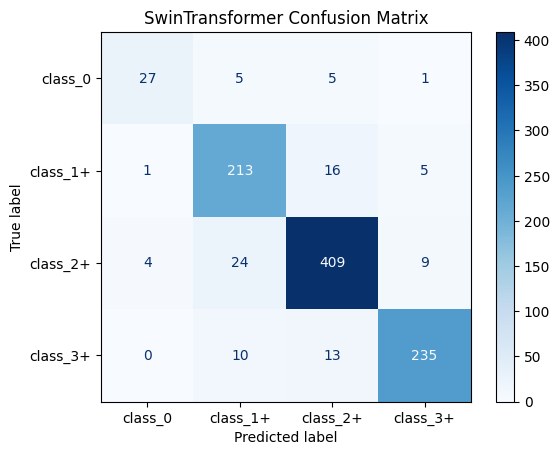

In [12]:
conf_matrix = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['class_0', 'class_1+', 'class_2+', 'class_3+'])
disp.plot(cmap=plt.cm.Blues)
plt.title("SwinTransformer Confusion Matrix")
plt.show()